In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import os
from datetime import datetime
from sklearn.metrics import roc_auc_score as auc
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

In [3]:
df = pd.read_csv("/Users/shawnmccarthy/Desktop/Independent Study/IsolationForest/data/creditcard.csv", sep=",", names=None, encoding="utf-8-sig")
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
TEST_RATIO = 0.5
df.sort_values('Time', inplace = True)
TRA_INDEX = int((1-TEST_RATIO) * df.shape[0])
train_x = df.iloc[:TRA_INDEX, 1:-2].values
train_y = df.iloc[:TRA_INDEX, -1].values

test_x = df.iloc[TRA_INDEX:, 1:-2].values
test_x_full = df.iloc[TRA_INDEX:].values
test_y = df.iloc[TRA_INDEX:, -1].values

In [5]:
cols_mean = []
cols_std = []
for c in range(train_x.shape[1]):
    cols_mean.append(train_x[:,c].mean())
    cols_std.append(train_x[:,c].std())
    train_x[:, c] = (train_x[:, c] - cols_mean[-1]) / cols_std[-1]
    test_x[:, c] =  (test_x[:, c] - cols_mean[-1]) / cols_std[-1]

In [6]:
from rbm import RBM

Instructions for updating:
non-resource variables are not supported in the long term


In [7]:
model = RBM(train_x.shape[1], 10, visible_unit_type='gauss', main_dir='./', model_name='rbm_model.ckpt',
                 gibbs_sampling_steps=4, learning_rate=0.001, momentum = 0.95, batch_size=512, num_epochs=10, verbose=1)

Validation cost at step 0: 1.105991
Validation cost at step 1: 1.0700814
Validation cost at step 2: 1.0243473
Validation cost at step 3: 0.994195
Validation cost at step 4: 0.9922749
Validation cost at step 5: 0.9902085
Validation cost at step 6: 0.9863234
Validation cost at step 7: 0.9926444
Validation cost at step 8: 0.992291
Validation cost at step 9: 0.9859181


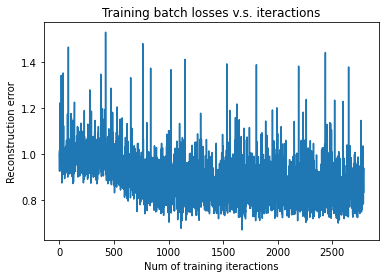

In [8]:
model.fit(train_x, validation_set=test_x)

In [9]:
test_cost = model.getFreeEnergy(test_x).reshape(-1)

INFO:tensorflow:Restoring parameters from ./rbm_model.ckpt


In [10]:

auc(test_y, test_cost)

0.9619968395618256

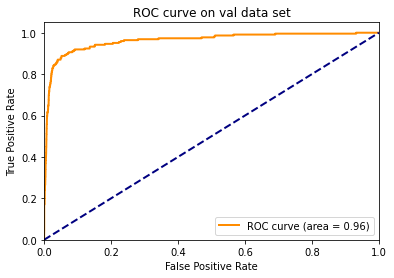

In [11]:

from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(test_y, test_cost)

fpr_micro, tpr_micro, _ = roc_curve(test_y, test_cost)
roc_auc = auc(fpr_micro, tpr_micro)

plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve on val data set')
plt.legend(loc="lower right")
plt.show()

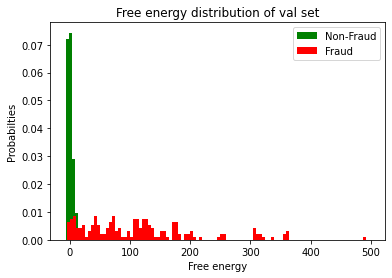

In [12]:
#plt.hist(test_cost[np.where(test_y == 1)], bins = 100)
plt.title('Free energy distribution of val set')
plt.xlabel('Free energy')
plt.ylabel('Probabilties')
plt.hist(test_cost[(test_y == 0) & (test_cost < 500)], bins = 100, color='green', density=1.0, label='Non-Fraud')
plt.hist(test_cost[(test_y == 1) & (test_cost < 500)], bins = 100, color='red', density=1.0, label = 'Fraud')

plt.legend(loc="upper right")
plt.show()

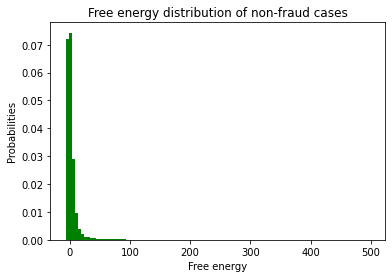

In [13]:
#plt.hist(test_cost[np.where(test_y == 1)], bins = 100)
plt.hist(test_cost[(test_y == 0) & (test_cost < 500)], bins = 100, color='green', density=1)
plt.title('Free energy distribution of non-fraud cases')
plt.xlabel('Free energy')
plt.ylabel('Probabilities')
plt.show()

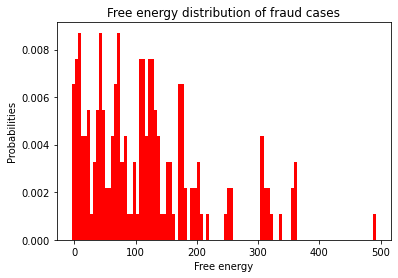

In [14]:
#plt.hist(test_cost[np.where(test_y == 1)], bins = 100)
plt.hist(test_cost[(test_y == 1) & (test_cost < 500)], bins = 100, color='red', density=1)
plt.title('Free energy distribution of fraud cases')
plt.xlabel('Free energy')
plt.ylabel('Probabilities')
plt.show()

In [15]:
anomaly = pd.DataFrame(test_x_full[test_y==1])
anomaly.head()

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
0,84694.0,-4.868108,1.264420,-5.167885,3.193648,-3.045621,-2.096166,-6.445610,2.422536,-3.214055,...,1.269205,0.057657,0.629307,-0.168432,0.443744,0.276539,1.441274,-0.127944,12.31,1.0
1,84789.0,-1.430864,-0.802529,1.123320,0.389760,-0.281214,-0.055123,1.326232,0.195700,-0.546890,...,0.325575,0.014002,0.844946,0.114963,0.156365,-0.619437,-0.120351,0.035594,354.33,1.0
2,85181.0,-3.003459,2.096150,-0.487030,3.069453,-1.774329,0.251804,-4.328776,-2.425478,-0.985222,...,0.163967,1.245648,-0.269241,0.537102,-0.220757,-0.059555,0.460710,-0.033551,2.00,1.0
3,85285.0,-7.030308,3.421991,-9.525072,5.270891,-4.024630,-2.865682,-6.989195,3.791551,-4.622730,...,1.103398,-0.541855,0.036943,-0.355519,0.353634,1.042458,1.359516,-0.272188,0.00,1.0
4,85285.0,-7.030308,3.421991,-9.525072,5.270891,-4.024630,-2.865682,-6.989195,3.791551,-4.622730,...,1.103398,-0.541855,0.036943,-0.355519,0.353634,1.042458,1.359516,-0.272188,0.00,1.0
